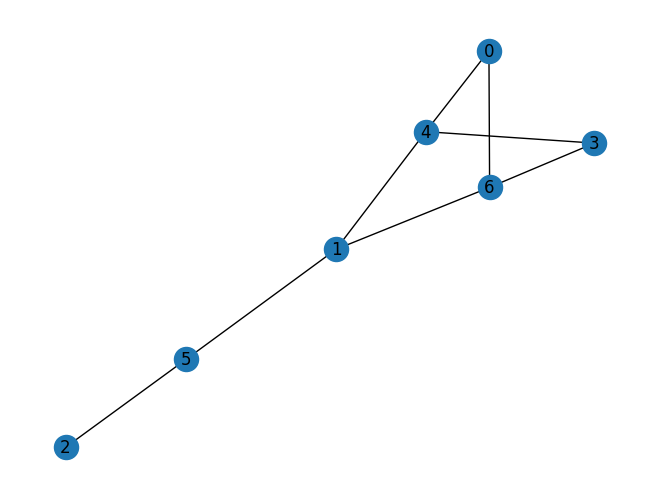

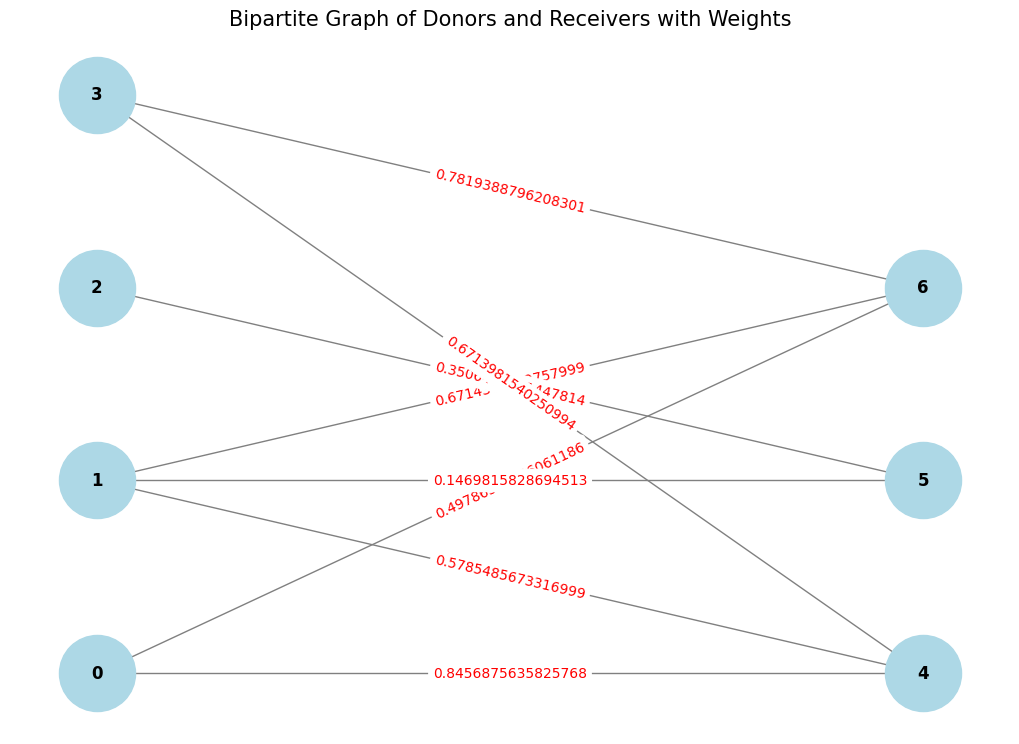

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Number of Donors and Receivers
num_donors = 4
num_receivers = 3

# Create integer-based node names
donors = list(range(num_donors))  # [0, 1, 2, 3]
receivers = list(range(num_donors, num_donors + num_receivers))  # [4, 5, 6]

# Compatibility matrix where True means a match is possible
# This can be based on medical data like blood type, etc.
compatibility = {
    (0, 4): True,
    (0, 5): False,
    (0, 6): True,
    (1, 4): True,
    (1, 5): True,
    (1, 6): True,
    (2, 4): False,
    (2, 5): True,
    (2, 6): False,
    (3, 4): True,
    (3, 5): False,
    (3, 6): True,
}
# Create a bipartite graph
B = nx.Graph()

# Add nodes with the bipartite label
B.add_nodes_from(donors, bipartite=0)
B.add_nodes_from(receivers, bipartite=1)

# Add edges based on compatibility
for donor, receiver in compatibility:
    if compatibility[(donor, receiver)]:
        B.add_edge(donor, receiver)
nx.draw(B, with_labels = True)  

pos = {}

# Assign positions to donors (left side)
for i, donor in enumerate(donors):
    pos[donor] = (-1, i)

# Assign positions to receivers (right side)
for i, receiver in enumerate(receivers):
    pos[receiver] = (1, i)
weighted = True
for (u, v) in B.edges():
    if weighted:
        w = random.uniform(0, 1)
    else:
        w = 1
    B.edges[u, v]['weight'] = w

# Draw the graph
plt.figure(figsize=(10, 7))
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw(B, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_color='red')
plt.title("Bipartite Graph of Donors and Receivers with Weights", size=15)
plt.show()

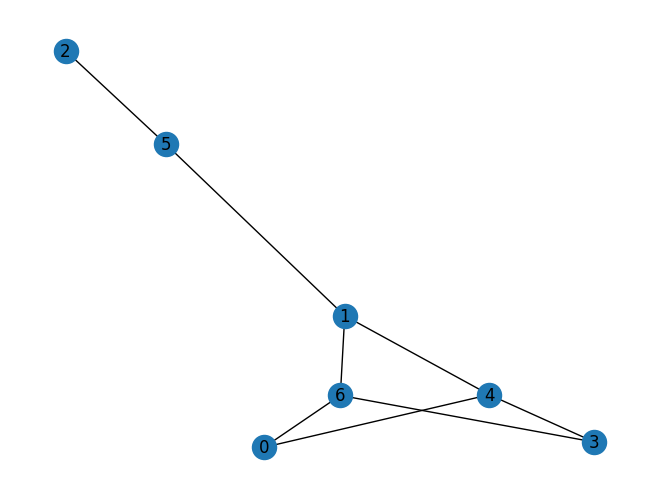

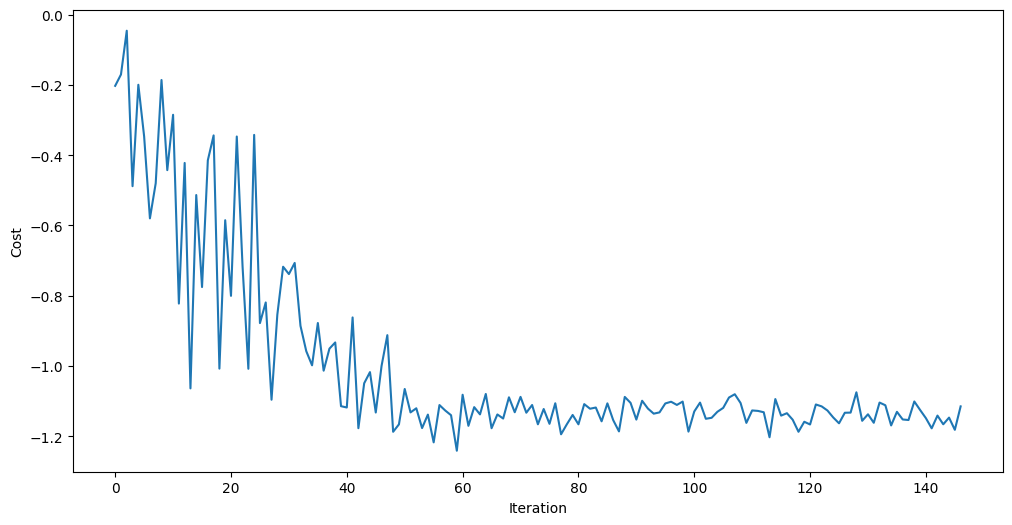

{'0111011': 15, '0100101': 2, '0001110': 3, '1001100': 12, '1010110': 13, '0100011': 24, '1110000': 2, '1001110': 39, '1100011': 49, '0011111': 15, '1001101': 12, '1110001': 3, '0111110': 6, '0011110': 8, '1100000': 22, '0101000': 22, '0010100': 21, '1101010': 75, '1100001': 6, '0011101': 8, '0000100': 7, '0110011': 8, '1011100': 29, '0011100': 48, '1010101': 49, '0101001': 21, '0010111': 2, '1101011': 16, '1111111': 2, '1000011': 3, '0000101': 7, '0101110': 4, '0110010': 16, '1000111': 13, '1111011': 3, '0110110': 1, '0101010': 50, '0111000': 8, '1000110': 2, '1111100': 4, '1010111': 17, '0010101': 72, '0011011': 6, '1110011': 1, '1001111': 7, '1110010': 7, '0111111': 1, '0100001': 5, '0001010': 6, '0101011': 2, '0110101': 6, '1111010': 10, '1000100': 20, '1001010': 9, '1010000': 6, '0010010': 1, '0101111': 1, '0110001': 29, '1100100': 4, '0011010': 5, '1101110': 4, '0001101': 3, '0111100': 3, '1001011': 5, '1100101': 8, '0010110': 3, '1000101': 4, '0000011': 4, '0010001': 3, '0111010

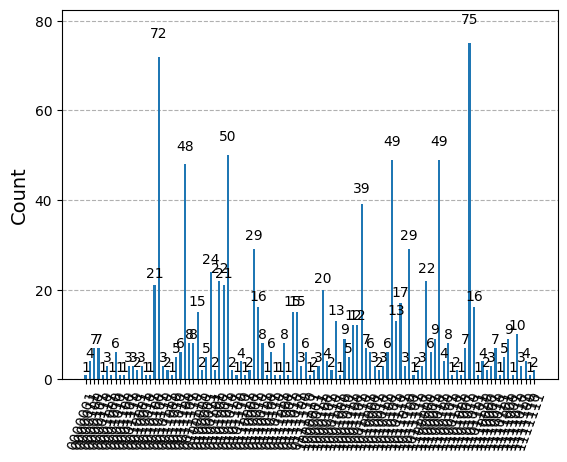

In [24]:
import networkx as nx
import numpy as np
import random
from itertools import combinations
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary, maximize
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

#service = QiskitRuntimeService(channel="ibm_quantum", token="4d675380adc3c0291ae0f7eebeb5011cf50f5ec7822256ec60f44a95eeae7a62ef3bed681f5b0ec3e8af0b30d7cb77445c71f13b9fbb90dbceb8d205dca56ad1")
#backend = service.backend(name = 'ibm_kyiv')  # Use a real quantum device if needed

#Local simulator parameters
aer_sim = AerSimulator(max_parallel_threads=10)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['u3'])

# sorunlu graph

nx.draw(B, with_labels = True)  
weighted = True

#PYOMO parametreleri
'''
model = ConcreteModel()

# Decision variables: x[i,j] = 1 if donor i is matched with recipient j
model.x = Var(B.edges(), within=Binary)

# Objective function: maximize the total weight of connections
def objective_rule(model):
    return sum(B.edges[i, j]['weight'] * model.x[i, j] for i, j in B.edges())
model.obj = Objective(rule=objective_rule, sense=maximize)  # Minimize negative, equivalent to maximize

#Constraints: Each donor and recipient is matched only once
def donor_constraint_rule(model, i):
    return sum(model.x[i, j] for j in G.neighbors(i) if (i, j) in model.x) <= 1
model.donor_constraint = Constraint(range(donors), rule=donor_constraint_rule)

def recipient_constraint_rule(model, j):
    return sum(model.x[i, j] for i in G.neighbors(j) if (i, j) in model.x) <= 1
model.recipient_constraint = Constraint(range(donors, donors + recipients), rule=recipient_constraint_rule)
'''

#QAOA KISMI 

# QAOA parameters
depth = 8
rep = 1000
qubits = list(range(num_donors + num_receivers))

# Her qubit için bir hadamard gate
def initialization(qc, qubits):
    for q in qubits:
        qc.h(q)

# Define the cost hamiltonian (CNOT,RZ,CNOT at bağlantılı nodes)
def cost_unitary(qc, qubits, gamma):
    for i, j in B.edges():
        qc.cx(qubits[i], qubits[j])
        qc.rz(2 * gamma * B.edges[i, j]['weight'], qubits[j])
        qc.cx(qubits[i], qubits[j])

# Define the mixer unitary
def mixer_unitary(qc, qubits, beta):
    for q in qubits:
        qc.rx(2 * beta, q)

# Create the QAOA circuit
def create_circuit(params):
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]

    qc = QuantumCircuit(num_donors + num_receivers)
    initialization(qc, qubits)

    for d in range(depth):
        cost_unitary(qc, qubits, gammas[d])
        mixer_unitary(qc, qubits, betas[d])

    qc.measure_all()
    return qc

objective_func_vals = []

def penalty_function(bit_list):
    penalty = 0
    for node in range(num_donors + num_receivers):
        connected_edges = [1 if (bit_list[i] == 1 and bit_list[j] == 1) else 0 for i, j in B.edges() if i == node or j == node]
        if sum(connected_edges) != 1:
            penalty += (sum(connected_edges) - 1) ** 2  # Penalize multiple connections
    return penalty

# Define the cost function
def cost_function(params):
    qc = create_circuit(params)
    transpiled_qc = transpile(qc, backend=aer_sim)
    job = aer_sim.run(transpiled_qc, shots=rep, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    total_cost = 0
    for bitstring, count in counts.items():
        bit_list = [int(bit) for bit in bitstring]
        
        # Calculate the total cost considering the weights
        cost = sum(B.edges[i, j]['weight'] * 0.5 * ((1 - 2 * bit_list[i]) * (1 - 2 * bit_list[j]) - 1) for i, j in B.edges())

        # Calculate the penalty for invalid configurations
        penalty = penalty_function(bit_list)
        
        # Weighted sum of cost and penalty
        total_cost += (cost + penalty * 0.3) * count
    
    total_cost = total_cost / rep
    objective_func_vals.append(total_cost)
    return total_cost


# Optimize using QAOA and Pyomo
optimal_params = None
optimal_val = np.inf

for _ in range(1):
    init = np.random.uniform(-np.pi, np.pi, 2 * depth)
    res = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':200})
    if res.fun < optimal_val:
        optimal_params = res.x
        optimal_val = res.fun
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
# Run the final circuit with the optimal parameters
qc = create_circuit(optimal_params)
transpiled_circuit = transpile(qc, backend=aer_sim)
job = aer_sim.run(transpiled_circuit, shots=rep, noise_model=noise_model)
result = job.result()
counts = result.get_counts()
print(counts)

plot_histogram(counts)



Process the results

In [ ]:
def is_valid_solution(bit_list):
    for node in range(num_donors + num_receivers):
        connected_edges = [1 if (bit_list[i] == 1 and bit_list[j] == 1) else 0 for i, j in B.edges() if i == node or j == node]
        if sum(connected_edges) != 1:
            return False
    return True

def get_best_solution(counts):
    best_solution = None
    best_cost = -np.inf

    for bitstring, count in counts.items():
        bit_list = [int(bit) for bit in bitstring]
        if is_valid_solution(bit_list):
            current_cost = 0
            for i, j in B.edges():
                current_cost += B.edges[i, j]['weight'] * 0.5 * ((1 - 2 * bit_list[i]) * (1 - 2 * bit_list[j]) - 1) * count
            if current_cost > best_cost:
                best_cost = current_cost
                best_solution = bit_list

    return best_solution

best_solution = get_best_solution(counts)

In [16]:
def parse_quantum_output(bitstring, nodes):
    """
    Parse a bitstring into a partition of nodes for MaxCut.
    Nodes with the same bit value are in one set, nodes with different bit values are in the other.
    """
    bit_list = [int(bit) for bit in bitstring]
    nodes = list(nodes)  # Ensure nodes is a list
    
    if len(bit_list) != len(nodes):
        raise ValueError("Bitstring length does not match the number of nodes")
    
    set1 = {nodes[i] for i, bit in enumerate(bit_list) if bit == 0}
    set2 = {nodes[i] for i, bit in enumerate(bit_list) if bit == 1}
    
    return set1, set2

def is_valid_solution(bitstring, num_donors, num_receivers):
    # Convert bitstring to list of integers if it's a string

    # Ensure the length is correct
    if len(bitstring) != num_donors + num_receivers:
        print(f"Bitstring length {len(bitstring)} does not match expected length {num_donors + num_receivers}")
        return False    

    # Separate donors and recipients based on bitstring
    donor_recipient_pairs = [(bitstring[i], bitstring[num_donors + i]) for i in range(num_donors)]

    for i in range(num_donors):
        if sum(donor_recipient_pairs[i]) > 1:
            print(f"Invalid donor connection: {donor_recipient_pairs[i]}")
            return False

    return True

def filter_valid_solutions(quantum_preds, num_donors, num_receivers):
    valid_solutions = []
    for bitstring in quantum_preds:
        print(f"Processing bitstring: {bitstring}")
        if is_valid_solution(bitstring, num_donors, num_receivers):
            valid_solutions.append(bitstring)
            print(f"Valid solution: {bitstring}")
        else:
            print(f"Invalid solution: {bitstring}")
    return valid_solutions

def find_optimal_solution(valid_solutions, B):
    if not valid_solutions:
        print("No valid solutions found")
        return None, None
    
    max_cost = -np.inf
    best_solution = None
    
    nodes = list(B.nodes)  # Convert to list if necessary
    
    for bitstring in valid_solutions:
        set1, set2 = parse_quantum_output(bitstring, nodes)
        
        # Calculate the cut value
        cut_value = sum(B.edges[u, v]['weight']
                        for u in set1
                        for v in set2
                        if B.has_edge(u, v))
        
        if cut_value > max_cost:
            max_cost = cut_value
            best_solution = bitstring
            
    return best_solution, max_cost


def visualize_solution(best_solution, B):
    if best_solution is None:
        print("No best solution available for visualization")
        return
    
    set1, set2 = parse_quantum_output(best_solution, B.nodes)
    
    pos = {node: (-1, i) for i, node in enumerate(set1)}
    pos.update({node: (1, i) for i, node in enumerate(set2)})
    
    # Extract edges for visualization from the parsed solution
    edges = [(u, v) for u in set1 for v in set2 if B.has_edge(u, v)]
    edge_labels = nx.get_edge_attributes(B, 'weight')
    
    plt.figure(figsize=(10, 7))
    nx.draw(B, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(B, pos, edgelist=edges, edge_color='red')
    nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Optimal Solution with MaxCut", size=15)
    plt.show()

# Example usage
quantum_preds = [list(map(int, bitstring)) for bitstring in counts if isinstance(bitstring, str)]
print(quantum_preds)

# Check bitstring lengths
for bitstring in quantum_preds:
    print(f"Bitstring length: {len(bitstring)}")
    print(f"Expected length: {len(B.nodes)}")
    break

[[0, 0, 0, 1, 1, 1, 0], [0, 1, 1, 1, 0, 1, 1], [1, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 0, 1, 0], [1, 0, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 1, 1], [1, 1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 1, 0], [1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0], [1, 0, 0, 0, 1, 1, 0], [1, 1, 0, 0, 0, 1, 0], [0, 1, 1, 0, 0, 0, 1], [0, 1, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 0], [1, 1, 1, 0, 1, 1, 1], [0, 0, 0, 1, 1, 0, 1], [0, 1, 1, 1, 0, 1, 0], [0, 1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1], [0, 0, 1, 0, 1, 1, 1], [1, 1, 0, 1, 0, 1, 1], [0, 0, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 1, 1], [1, 0, 1, 1, 1, 0, 1], [0, 1, 1, 1, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 0, 1, 0], [1, 1, 0, 0, 1, 0, 0], [1, 0, 1, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1], [1, 1, 1, 0, 0, 1, 0], [1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 1], [0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 1, 1], [1, 0, 0, 1, 1, 1, 1], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 1], [1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 

In [175]:
bitstring = [
    "101010",  # Example bitstring
    "010101",
    "111000"
]
valid_solutions = filter_solutions(bitstring, 2, 1)

print("Valid solutions:")
for solution in valid_solutions:
    print(solution)

Bitstring length 6 does not match expected length 2
Bitstring length 6 does not match expected length 2
Bitstring length 6 does not match expected length 2
Valid solutions:


In [20]:
top_valid_solutions = []
top_valid_solutions = filter_valid_solutions(quantum_preds, num_donors,num_receivers)

print("Valid solutions:")
for solution in top_valid_solutions:
    print(solution)

Processing bitstring: [0, 0, 0, 1, 1, 1, 0]


IndexError: list index out of range

In [84]:
# Calculate classical cuts for comparison
sub_lists = []
for i in range(num_donors + num_receivers + 1):
    temp = [list(x) for x in combinations(B.nodes(), i)]
    sub_lists.extend(temp)

cut_classic = []
for sub_list in sub_lists:
    cut_classic.append(nx.algorithms.cuts.cut_size(B, sub_list, weight='weight'))

cut_quantum = []
for cut in quantum_preds:
    cut_quantum.append(nx.algorithms.cuts.cut_size(B, cut, weight='weight'))
    print(cut_quantum)

print("Quantum mean cut:", np.max(cut_quantum))
print("Max classical cut:", np.max(cut_classic))
print("Ratio:", np.max(cut_quantum) / np.max(cut_classic))

[1.4151017548617837]
[1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837]
[1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.4151017548617837, 1.41510175

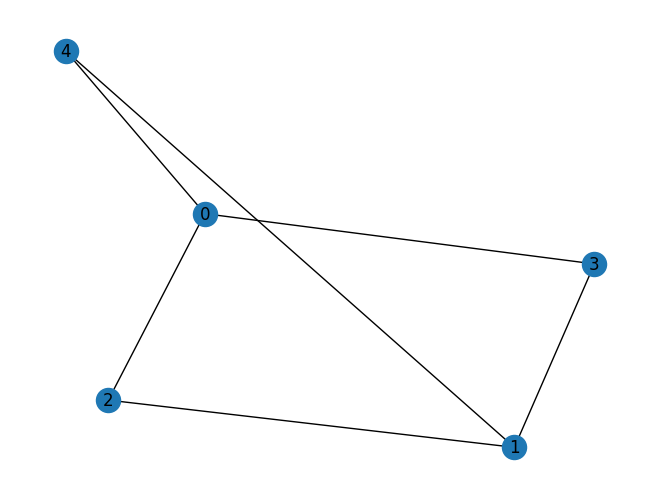